# 학습목표
* 딥러닝 모델을 저장하고 복원하는 방법에 대해서 설명할 수 있습니다.
* 모델 학습 시에 사용할 수 있는 콜백 함수에 대해 설명할 수 있습니다.

# MNIST 딥러닝 모델 예제
딥러닝을 처음 배우는 사람들이 만나게되는 데이터 셋    
손글씨 숫자들로 우리어진 이미지 데이터셋이 MNIST 데이터 셋이다.    
MNIST는 keras.datasets에 기본으로 포함되어있다.

In [2]:
# 모듈 임포트
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, utils

## 데이터 로드 및 전처리
* MNIST 데이터셋을 로드하기 위해서 케라스의 데이터셋에 내장되어 있는 tensorflow.keras.datasets.mnist를 임포트
* train_test_split() 함수를 이용해 학습용 데이터인 x_train_full와 y_train_full를 나눈다.
* 70%는 학습용 데이터인 x_train와 y_train으로 사용하고, 30%는 검증 데이터인 x_val와 y_val로 사용

데이터셋이 어떻게 구성되었는지 출력해보면, 전체 60,000개의 학습 데이터 중에서 70%인 42,000개가 학습용 데이터로 나눠지고,     
30%인 18,000개가 검증용 데이터로 나눠졌으며, 테스트용으로는 10,000개가 주어진 것을 알 수 있습니다.

In [3]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data(path='mnist.npz')

x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full,
                                                  test_size=0.3,
                                                  random_state=123)

print(f"전체 학습 데이터: {x_train_full.shape}  레이블: {y_train_full.shape}")
print(f"학습용 데이터: {x_train.shape}  레이블: {y_train.shape}")
print(f"검증용 데이터: {x_val.shape}  레이블: {y_val.shape}")
print(f"테스트용 데이터: {x_test.shape}  레이블: {y_test.shape}")

전체 학습 데이터: (60000, 28, 28)  레이블: (60000,)
학습용 데이터: (42000, 28, 28)  레이블: (42000,)
검증용 데이터: (18000, 28, 28)  레이블: (18000,)
테스트용 데이터: (10000, 28, 28)  레이블: (10000,)


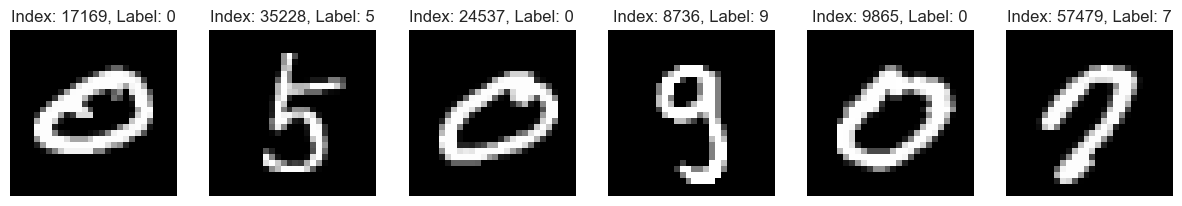

In [4]:
# MNIST 데이터셋에 실제 숫자 이미지가 어떻게 구성되어 있는지 60,000개 중에서 6개만 랜덤으로 x_train_full과 y_train_full에서 추출
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 이부분 matplotlib 업데이트 되면서 없어진 부분
sns.set_style('white')
# plt.style.use("seaborn-white")

num_sample = 6
random_idxs = np.random.randint(60000, size=num_sample)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_idxs):
  img = x_train_full[idx, :]
  label = y_train_full[idx]

  plt.subplot(1, len(random_idxs), i+1)
  plt.axis('off')
  plt.title(f'Index: {idx}, Label: {label}')
  # 여기를 gray로 해줘야 색깔이 흑백으로
  plt.imshow(img, cmap='gray')

MNIST의 학습용 데이터가 실제 값으로는 어떻게 구성되어있는지 출력을 해보면, y_train의 0번째는 4라는 값이 저장되어 있는걸 알 수 있고,     
x_train의 0번째에는 숫자 4에 대한 이미지를 0~255 사이의 값으로 표현하고 있음을 알 수 있습니다.

In [6]:
# y_train 0번째값 추출해보기
print(y_train[0])

4


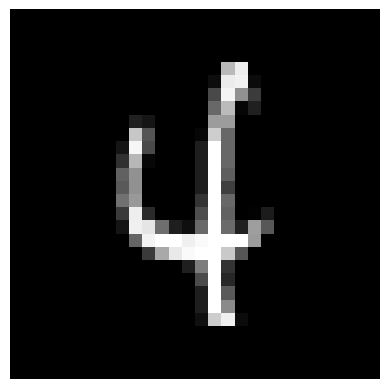

In [7]:
img = x_train[0, :]
plt.axis('off')
plt.imshow(img, cmap='gray')

In [8]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 184 236
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  13 235 240
   11   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  73 244 144
   59   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 104 186   6
   32   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  33  21   0   0   0   0 15

* MNIST 데이터셋을 가지고 본격적으로 딥러닝 모델에 사용하기 위해서는 전처리 과정이 필요하다.
* 본 예제에서는 간단한 전처리만 사용해서 x_train, x_val 그리고 x_test의 값들을 255로 나누어준다.
* 이미지의 픽셀이 표현하는 값의 범위가 0 ~ 255이기 때문에 최대값인 255로 나누어주면, 값이 0 ~ 1 사이의 범위로 스케일링되어 학습에 용이해짐

y_train, y_val, 그리고 y_test의 경우에는 0부터 9까지의 숫자를 나타내는 레이블이기 때문에 총 10개의 값을 가지는 범주형입니다.     
따라서 utils.to_categorical을 이용해 **원-핫 인코딩**을 수행합니다. 즉 정답에는 1을, 나머지의 값은 0을 부여합니다.

In [9]:
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

print(y_train[0])
print(y_val[0])
print(y_test[0])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


## 모델 구성
1. 딥러닝 모델 구성을 위해 Sequential() 함수를 이용해 순차적으로 레이어를 구성
2. 먼저 MNIST 데이터셋의 숫자 이미지가 28 x 28 사이즈를 사용하므로 입력 객체로 keras.Input를 사용할 때, shape을 (28, 28)로 지정
3. 차원으로 쭉 펼쳐주는 layers.Flatten 레이어를 사용하여 입력 데이터 모양이 2차원인 28 x 28 크기를 1차원으로 784 크기를 갖도록 변형
4. 레이어로 layers.Dense를 여러겹 사용하여 유닛수를 100, 64, 32, 10으로 4겹 쌓아주고, 활성화 함수로 relu를 사용
5. MNIST의 숫자가 0부터 9까지 총 10개 이므로 마지막 레이어에서는 전체 카테고리의 수인 10을 유닛수로 지정
6. 활성화 함수는 softmax를 사용하여 각 카테고리별 확률 값을 구한다.

In [10]:
model = models.Sequential()

model.add(keras.Input(shape=(28, 28), name='input'))
model.add(layers.Flatten(input_shape=[28, 28], name='flatten'))
model.add(layers.Dense(100, activation='relu', name='dense1'))
model.add(layers.Dense(64, activation='relu', name='dense2'))
model.add(layers.Dense(32, activation='relu', name='dense3'))
model.add(layers.Dense(10, activation='softmax', name='output'))

model.summary()

C:\Users\nini\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,374 (341.30 KB)

 Trainable params: 87,374 (341.30 KB)

 Non-trainable params: 0 (0.00 B)

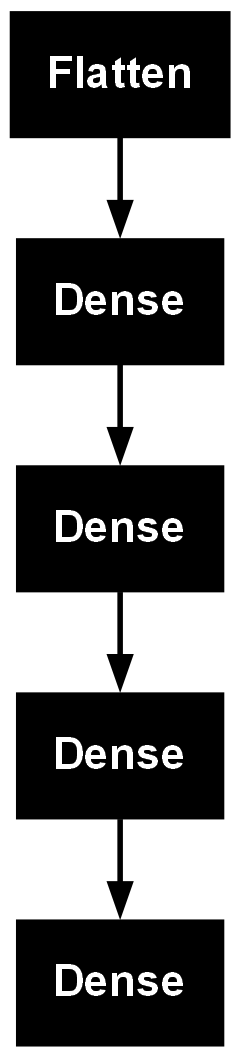

In [11]:
# 생성한 모델 구성 확인
utils.plot_model(model)

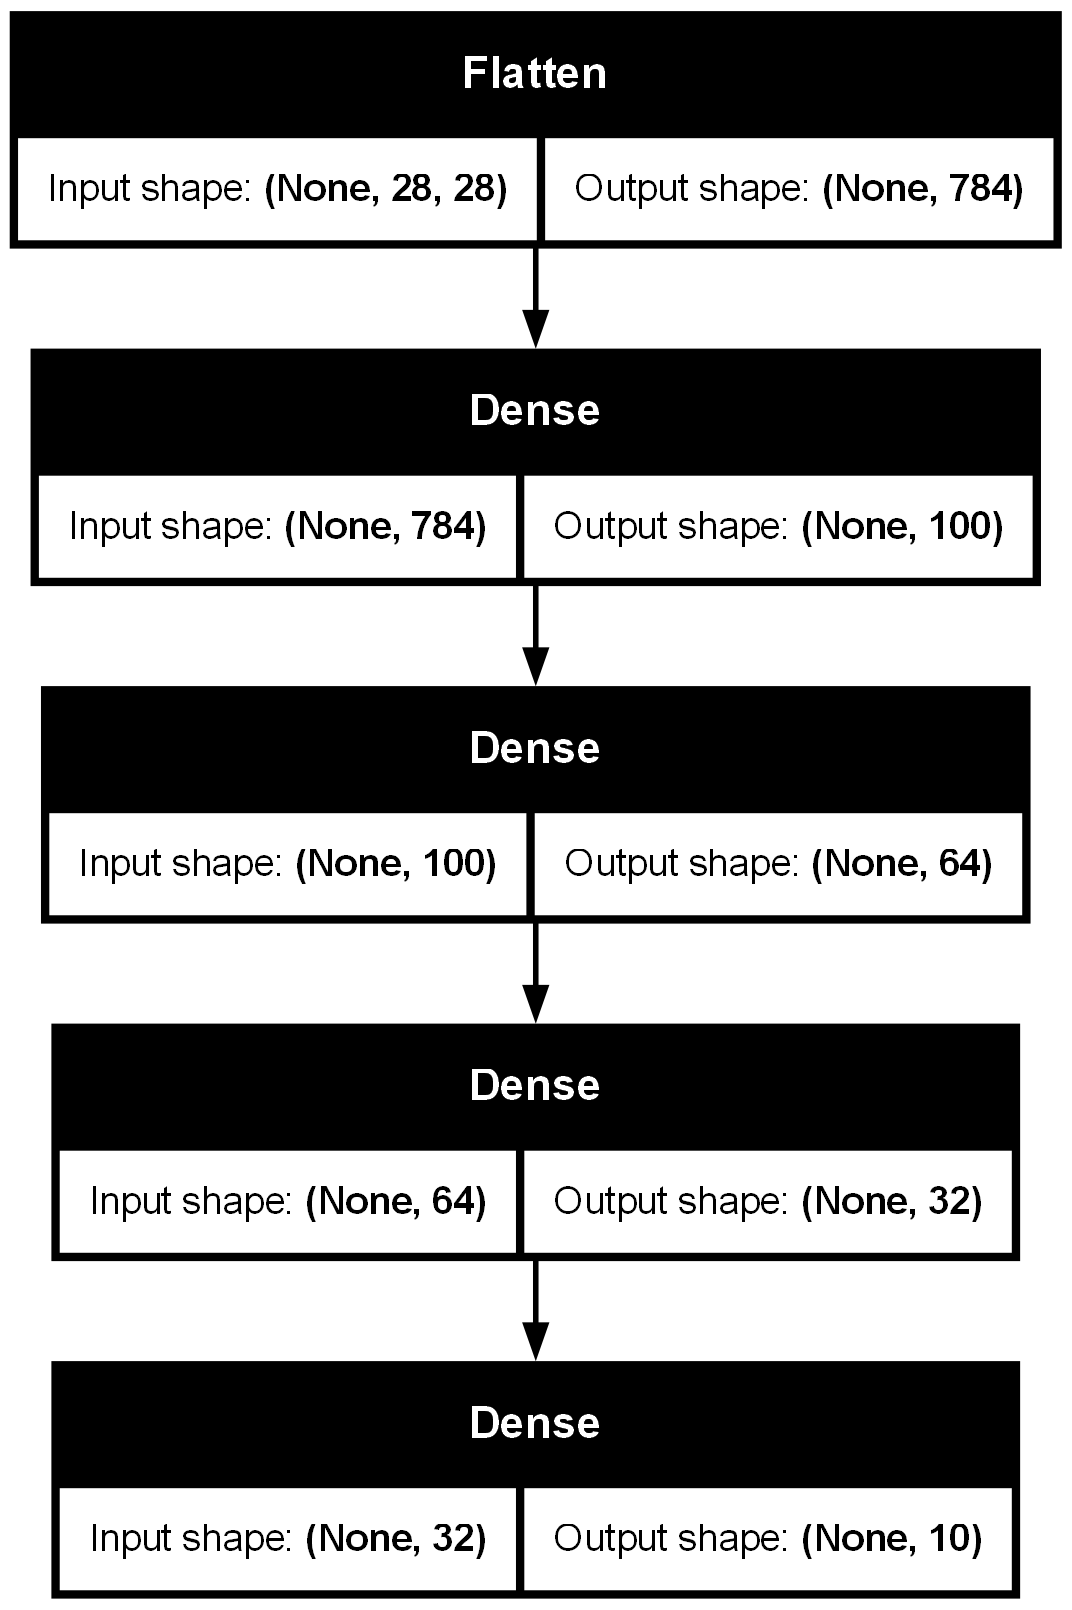

In [12]:
# 모델 구성 레이어의 모양 확인
utils.plot_model(model, show_shapes=True)

## 모델 컴파일 및 학습
1. 구성한 모델에 손실 함수로는 다중 분류로 클래스가 원-핫 인코딩 방식으로 되어 있을 때 사용하는 categorical_crossentropy를 지정
2. 옵티마이저는 가장 기본적인 sgd을 지정한다.
3. 분류에 대한 성능을 확인하기 위한 지표로 accuracy(정확도)를 지정한다.

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

이제 본격적으로 딥러닝 모델을 학습하기 위해 fit을 실행    
1. 이때 학습에 사용되는 데이터로 x_train과 y_train을 지정
2. 학습을 반복하는 에폭 수(epochs)는 40으로 지정
3. 배치 사이즈(batch_size)는 128로 지정
4. 검증을 위해서 나누었던 데이터로 x_val와 y_val을 지정

In [14]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_val, y_val))

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3461 - loss: 1.9840 - val_accuracy: 0.8009 - val_loss: 0.8659
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8309 - loss: 0.7124 - val_accuracy: 0.8661 - val_loss: 0.4949
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8778 - loss: 0.4598 - val_accuracy: 0.8828 - val_loss: 0.4104
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8917 - loss: 0.3858 - val_accuracy: 0.8939 - val_loss: 0.3659
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8996 - loss: 0.3480 - val_accuracy: 0.9019 - val_loss: 0.3449
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9082 - loss: 0.3249 - val_accuracy: 0.9084 - val_loss: 0.3139
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9177 - loss: 0.2955 - val_accuracy: 0.9083 - val_loss: 0.3081
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9187 - loss: 0.2861 - val_accuracy: 0.

모델이 학습을 진행하면서 각 에폭마다 지표 결과들을 history로 저장한다.    
저장된 형태를 보면 loss, accuracy, val_loss, val_accuracy로 구분되는걸 알 수 있다.

In [16]:
# history로 저장
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

history에 저장된 결과 값들이 에폭이 진행되면서 변화되는 추이를 살펴보기 위해서 시각화한다.    
첫 번째 차트에서는 loss와 val_loss를 함께 보여주고, 두 번째 차트에서는 accuracy와 val_accuracy를 함께 보여준다.

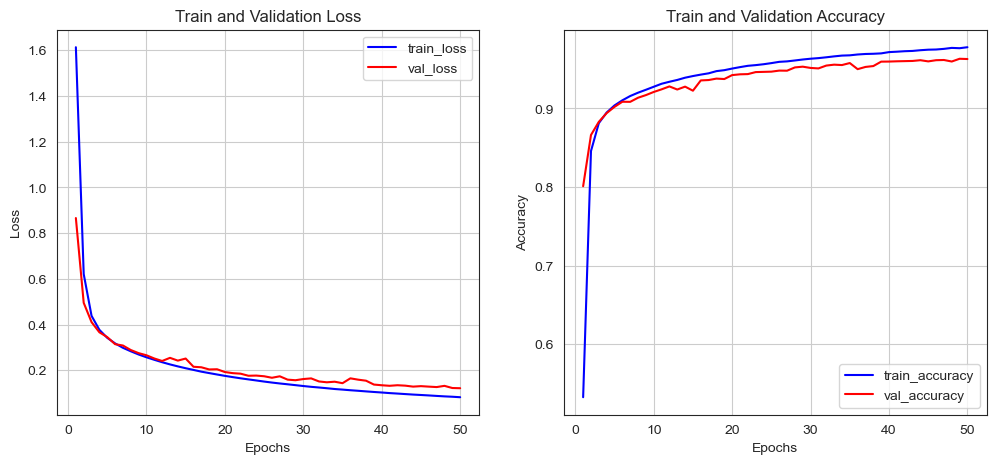

In [17]:
history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

## 모델 평가 및 예측
학습된 모델의 평가를 위해서 x_test와 y_test를 대상으로 evaluate() 함수를 동작시킨다.

In [18]:
model.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9593 - loss: 0.1324


[0.11336561292409897, 0.9659000039100647]

학습된 모델의 예측을 위해 x_test를 넣고, 그에 대한 예측 결과를 받아서 0번째 결과만 확인    
최종 레이어인 유닛 수 10개의 softmax를 활성화 함수로 통과한 결과인 것을 알 수 있다.

In [19]:
pred_ys = model.predict(x_test)
print(pred_ys.shape)
print(pred_ys[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 10)
[2.1890930e-05 2.2326999e-06 5.7565561e-05 4.6421523e-04 1.1834913e-08
 2.4747110e-06 2.8356721e-11 9.9939418e-01 2.2931245e-06 5.5188411e-05]


결과값 중에서 가장 큰 수가 있는 위치값을 np.argmax()를 통해서 구한다.    
예측한 레이블 값 arg_pred_y[0]과 실제 숫자 이미지인 x_test[0]를 출력해보기.

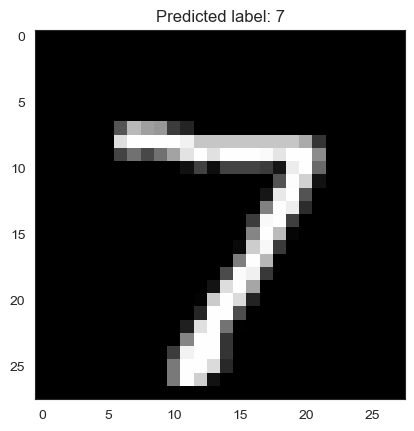

In [22]:
# arg_pred_y = np.argmax(pred_ys, axis=1)

# plt.title(f'Predicted label: {arg_pred_y[0]}')
# plt.imshow(x_test[0], cmap='cmap')
# plt.show()

arg_pred_y = np.argmax(pred_ys, axis=1)

plt.title(f'Predicted label: {arg_pred_y[0]}')
plt.imshow(x_test[0], cmap='gray')
plt.show()

모델이 제대로 분류를 수행했는지 알기 위해서 사이킷런(Scikit-Learn)에 포함된     
classification_report를 임포트해서 각종 지표들을 한눈에 살펴보기

In [23]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=-1), np.argmax(pred_ys, axis=-1)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.98      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.97      0.94      0.96       892
           6       0.96      0.97      0.96       958
           7       0.97      0.96      0.97      1028
           8       0.95      0.96      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



각 레이블 별로 분류가 얼마나 잘 수행되었는지 한눈에 살펴볼 수 있도록 혼동 행렬(Confusion Matrix)을 이용해 시각화

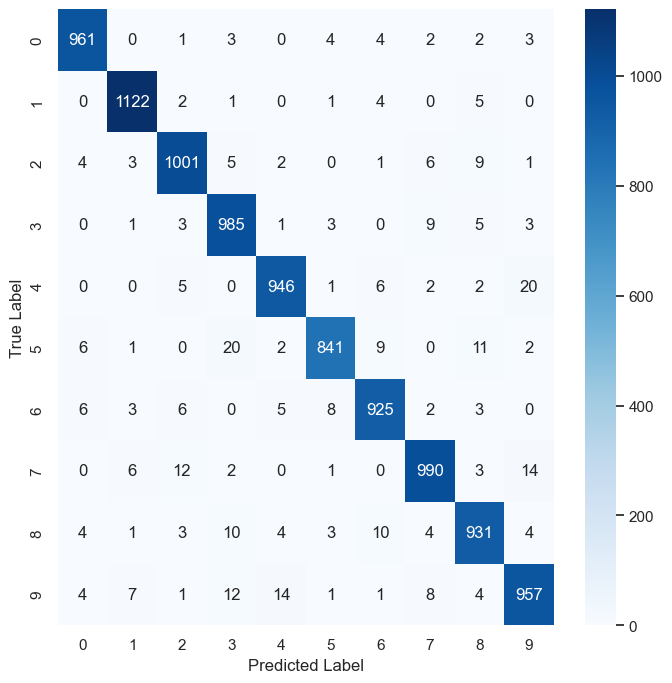

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(8, 8))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_ys, axis=-1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 모델 저장과 로드
모델을 열심히 학습시키고 저장을 안한다면 다시 처음부터 학습을 해야한다.    
어느 정도 학습이 되었다면 추후에 모델을 사용하기 위해서 저장할 필요가 있다.     
모델을 저장할 때는 save() 함수를 사용하여 쉽게 저장할 수 있다.    
다시 모델을 불러올 때는 load_model() 함수를 사용    

모델을 저장하고 로드하는 것에서 중요한 점은 모델 생성 시에 Sequencial API 또는 Functional API를 사용한 경우에는     
모델의 저장 및 로드가 가능하지만 Subclassing API 방식은 사용할 수가 없다.    

Subclassing API 방식은 `save_weights()`와 `load_weights()`를 이용해 모델의 파라미터만 저장 및 로드하는 것이 가능하다.    
만약 JSON 형식으로 모델을 저장하려면 to_json()를 사용하여 가능하고, JSON 파일로부터 모델을 로드하려면 model_from_json()을 사용하면 된다.    
그 밖에도 YAML로 직렬화하여 저장할 경우 to_yaml()를 사용하고, model_from_yaml()를 사용하여 로드한다.

**정리** 모델을 저장하는 파일형식 3가지    
* .h5 파일 => model.save('model.h5')
* json 파일 => model.to_json()
* yaml 파일 => model.to_yaml()

실습을 통해 모델 저장과 로드하기    
`mnist_model.h5`라는 이름으로 모델을 저장한다.

In [25]:
# 모델 저장하기
model.save('mnist_model.h5')

In [26]:
# mnist_model.h5라는 이름의 모델을 로드하여 가져오기
loaded_model = models.load_model('mnist_model.h5')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense3 (Dense)                  │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,376 (341.32 KB)

 Trainable params: 87,374 (341.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [27]:
# 로드한 모델을 이용하여 예측
pred_ys2 = loaded_model.predict(x_test)

print(pred_ys2.shape)
print(pred_ys2[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(10000, 10)
[2.1890930e-05 2.2326999e-06 5.7565561e-05 4.6421523e-04 1.1834913e-08
 2.4747110e-06 2.8356721e-11 9.9939418e-01 2.2931245e-06 5.5188411e-05]


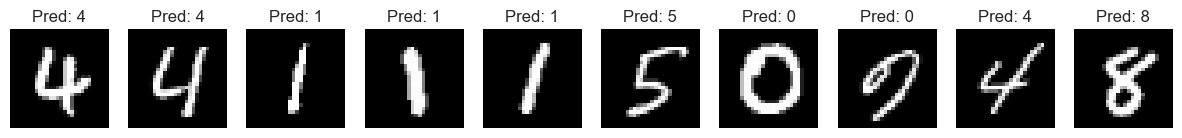

In [28]:
# 로드한 모델이 예측한 결과값을 시각화
arg_pred_y2 = np.argmax(pred_ys2, axis=1)

#matlotlib를 이용해서 시각화하기
# 샘플 개수 설정
num_samples = 10
indices = np.random.choice(len(x_test), num_samples, replace=False)

plt.figure(figsize=(15, 4))
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(x_test[idx], cmap='gray')  # 이미지일 경우
    plt.title(f"Pred: {arg_pred_y2[idx]}")
    plt.axis('off')
plt.show()

In [29]:
# to_json() 함수를 이용해 모델을 저장해보고 다시 불러서 결과를 확인해보기

# 위에서 학습시킨 model의 구조를 json 형식으로 model_json에 저장합니다.
model_json = model.to_json()

# json으로 저장한 모델을 읽어옵니다.
loaded_model = keras.models.model_from_json(model_json)

predictions = loaded_model.predict(x_test)
print(predictions.shape)
print(predictions[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
(10000, 10)
[0.06767337 0.11275098 0.09804747 0.11653063 0.07931028 0.08804551
 0.13343477 0.09647248 0.14320037 0.06453414]


# 콜백 (Callbacks)
1. ModelCheckpoint
   *  정기적으로 모델의 체크포인트를 저장하고, 문제가 발생할 때 복구하는데 사용
2. EarlyStopping
   * 검증 성능이 한동안 개선되지 않을 경우 학습을 중단할 때 사용
   * 일정 patience 동안 검증 세트에 대한 점수가 오르지 않으면 학습을 멈추게된다.
   * 모델이 향상되지 않으면 학습이 자동으로 중지되므로, epochs 숫자를 크게 해도 무방하다.
   * 학습이 끝난 후의 최상의 가중치를 복원하기 때문에 모델을 따로 복원할 필요가 없다.
3. LearningRateScheduler
   * 최적화를 하는 동안 학습률(learning_rate)를 동적으로 변경할 때 사용
   * 에폭수가 처음에는 많이 주다가 학습 할 수록 줄이고 싶을 때 사용할 수 있다.
   * 예를들어 에폭 수가 10 미만일 경우는 학습률을 그대로 하고, 10 이상이 되면 -0.1%씩 감소시킬 수 있다.
4. Tensorboard
   * 모델의 경과를 모니터링할 때 사용

In [33]:
# 콜백 라이브러리 불러오기
from tensorflow.keras import callbacks

In [34]:
# ModelCheckpoint
check_point_cb = callbacks.ModelCheckpoint('keras_mnist_model.h5')
history = model.fit(x_train, y_train, epochs=10,
                    callbacks=[check_point_cb])

Epoch 1/10
1297/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9747 - loss: 0.0860

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9747 - loss: 0.0860
Epoch 2/10
1301/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9741 - loss: 0.0845

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9741 - loss: 0.0845
Epoch 3/10
1308/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9784 - loss: 0.0777

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9784 - loss: 0.0777
Epoch 4/10
1310/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.0728

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9798 - loss: 0.0728
Epoch 5/10
1299/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9796 - loss: 0.0715

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9796 - loss: 0.0714
Epoch 6/10
1299/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9821 - loss: 0.0627

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9821 - loss: 0.0627
Epoch 7/10
1303/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9841 - loss: 0.0579

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9841 - loss: 0.0579
Epoch 8/10
1307/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9853 - loss: 0.0528

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9853 - loss: 0.0528
Epoch 9/10
1293/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0485

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9862 - loss: 0.0486
Epoch 10/10
1311/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0464

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9873 - loss: 0.0464


In [35]:
# 최상의 모델만을 저장하는 옵션으로 save_best_only=True를 지정
check_point_cb = callbacks.ModelCheckpoint('keras_mnist_model.h5', save_best_only=True)
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb])

Epoch 1/10
1299/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9869 - loss: 0.0470

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9870 - loss: 0.0470 - val_accuracy: 0.9666 - val_loss: 0.1161
Epoch 2/10
1310/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0412

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9884 - loss: 0.0412 - val_accuracy: 0.9697 - val_loss: 0.1045
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9905 - loss: 0.0379 - val_accuracy: 0.9687 - val_loss: 0.1108
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9899 - loss: 0.0383 - val_accuracy: 0.9682 - val_loss: 0.1062
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9914 - loss: 0.0348 - val_accuracy: 0.9676 - val_loss: 0.1062
Epoch 6/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9919 - loss: 0.0319 - val_accuracy: 0.9693 - val_loss: 0.1068
Epoch 7/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9925 - loss: 0.0290 - val_accuracy: 0.9653 - val_loss: 0.1256
Epoch 8/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9922 - loss: 0.0287 - val_accuracy: 0.9677 - val_loss: 0.1097
Epoch 9/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9921 - loss: 0.0290 - val_accurac

In [36]:
# EarlyStopping
check_point_cb = callbacks.ModelCheckpoint('keras_mnist_model.h5', 
                                           save_best_only=True)

early_stopping_cb = callbacks.EarlyStopping(patience=3, 
                                            monitor='val_loss',
                                            restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/10
1301/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0218

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9955 - loss: 0.0218 - val_accuracy: 0.9685 - val_loss: 0.1121
Epoch 2/10
1297/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9953 - loss: 0.0216

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9953 - loss: 0.0216 - val_accuracy: 0.9701 - val_loss: 0.1088
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9963 - loss: 0.0187 - val_accuracy: 0.9695 - val_loss: 0.1128
Epoch 4/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9960 - loss: 0.0182 - val_accuracy: 0.9698 - val_loss: 0.1106
Epoch 5/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9964 - loss: 0.0176 - val_accuracy: 0.9676 - val_loss: 0.1186


In [37]:
# LearningRateScheduler
# 에폭 수가 10 미만일 경우는 학습률을 그대로 하고, 10 이상이 되면 -0.1%씩 감소시키는 코드

# 반환값을 float로 바꿔주기
def scheduler(epoch, learning_rate):
  if epoch < 10:
    return float(learning_rate)
  else:
    return float(learning_rate * tf.math.exp(-0.1))

In [38]:
# round(model.optimizer.lr.numpy(), 5)

# 아래로 바뀜
round(model.optimizer.learning_rate.numpy(), 5)

0.01

In [39]:
lr_scheduler_cb = callbacks.LearningRateScheduler(scheduler)

history = model.fit(x_train, 
                    y_train, 
                    epochs=15,
                    callbacks=[lr_scheduler_cb], verbose=0)

# 여기도 lr을 learning_rate로 변경
round(model.optimizer.learning_rate.numpy(), 5)

0.00607

In [48]:
# Tensorboard
# 텐서보드를 이용하여 학습과정을 모니터링하기 위해서는 logs 폴더를 만들고, 학습이 진행되는 동안 로그 파일을 생성
# 텐서보드에는 효율적인 모니터링을 위해서 여러가지 기능들을 제공한다.
# 다음에 오류 해결해보기!!

log_dir = './logs'
tensor_board_cb = [callbacks.TensorBoard(log_dir=log_dir, 
                                         histogram_freq=1, 
                                         write_graph=True, 
                                         write_images=True)]

model.fit(x_train, 
          y_train, 
          batch_size=32, 
          validation_data=(x_val, y_val),
          epochs=30, 
          callbacks=tensor_board_cb)

FailedPreconditionError: {{function_node __wrapped__CreateSummaryFileWriter_device_/job:localhost/replica:0/task:0/device:CPU:0}} ./logs is not a directory [Op:CreateSummaryFileWriter] name: 

In [49]:
# 다음에 텐서보드 실행해보기
%load_ext tensorboard
%tensorboard --logdir {log_dir}

### 복습하기

In [50]:
# 기존에 사용했던 mnist의 데이터들을 활용해서 모델에 checkpoint를 만들고 Earlystopping을 설정해주세요.
# Checkpoint 콜백
check_point_cb = callbacks.ModelCheckpoint("best_model.h5",
                                           save_best_only=True,
                                           monitor="val_loss",
                                           verbose=1)

# EarlyStopping 콜백
early_stopping_cb = callbacks.EarlyStopping(monitor="val_loss",
                                             patience=3,
                                             restore_best_weights=True,
                                             verbose=1)

history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/10
1300/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0060
Epoch 1: val_loss improved from inf to 0.11961, saving model to best_model.h5


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9995 - loss: 0.0060 - val_accuracy: 0.9704 - val_loss: 0.1196
Epoch 2/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0060
Epoch 2: val_loss improved from 0.11961 to 0.11889, saving model to best_model.h5


1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9995 - loss: 0.0060 - val_accuracy: 0.9709 - val_loss: 0.1189
Epoch 3/10
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0054
Epoch 3: val_loss did not improve from 0.11889
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9998 - loss: 0.0054 - val_accuracy: 0.9708 - val_loss: 0.1236
Epoch 4/10
1296/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0057
Epoch 4: val_loss did not improve from 0.11889
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9997 - loss: 0.0057 - val_accuracy: 0.9697 - val_loss: 0.1220
Epoch 5/10
1295/1313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0050
Epoch 5: val_loss did not improve from 0.11889
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9999 - loss: 0.0050 - val_accuracy: 0.9711 - val_loss: 0.1218
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


# 최종 학습 정리
이번 노드를 통해서 MNIST 데이터 셋을 사용해서 전처리를 하고 모델을 구성해서 확인해보고 최종적으로 모델을 만들어봤다.    
위 모델을 또 사용하기 위해 save() 함수를 통해 저장하고 다시 로드해서 사용해 봤다.    
모델을 저장하는 파일형식은 `.h5`, `json`, `yaml` 형식이 있다.    
세번째는 콜백 함수에 대해 학습했고 콜백에는 크게 문제가 발생할 때 복구하는데 사용할 수 있는`ModelCheckpoint`,     
모델이 향상되지 않으면 학습이 자동으로 중지되고 최상의 가중치를 복원해주는 기능이 있는 `EarlyStopping`,     
학습율을 동적으로 변경할 수 있는`LearningRateScheduler`, 모델의 경과를 모니터링 할 때 사용하는 `Tensorboard` 가 있다.